# Pendulum Wind-Speed Calibration (v = sqrt(a * tan(theta)))

This notebook calibrates a pendulum-based wind sensor with:

- **Model:** $$v = \sqrt{a \tan \theta}$$
- **Optional global gain:** \(g\) so the output becomes \(g\sqrt{a \tan\theta}\)

**Workflow**
1. Load a synced CSV with columns: `t_rel_s`, `ground_truth_mps`, and an angle column (`theta_rad` / `theta_deg` / `angle_rad` / `angle_deg`).
2. Detect angle units and convert to radians.
3. Fit **a** via least-squares on \(v^2 = a \tan\theta\).
4. Optionally fit a global **gain g** to minimize MSE.
5. Report **R²** and **MSE**. Plot time series and residuals.
6. Save parameters and predictions for deployment.


In [123]:
# %% [markdown]
# # Pendulum Calibration + EKF Tuning
# v = sqrt(a * tan(theta))

# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# ---------- USER CONFIG ----------
CSV_PATH   = "part_2_test_12_synced.csv"   # <-- change to your dataset
COL_TIME   = "t_rel_s"             # optional; if missing, an index will be used
COL_SPEED  = "ground_truth_mps"    # reference wind (m/s)
COL_ANG_DEG= "student_mps"           # preferred if present

# Output
OUT_CSV    = "pendulum_calibrated_ekf.csv"

In [124]:
# %%
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip().str.lower()

# Check reference
if COL_SPEED.lower() not in df.columns:
    raise ValueError(f"Missing '{COL_SPEED}'. Found: {sorted(df.columns)}")

# Pick angle column
if COL_ANG_DEG.lower() in df.columns:
    angle_rad = np.deg2rad(df[COL_ANG_DEG.lower()].astype(float).to_numpy())

# Time (optional)
t = (df[COL_TIME.lower()].astype(float).to_numpy()
     if COL_TIME.lower() in df.columns
     else np.arange(len(df), dtype=float))

v_ref = df[COL_SPEED.lower()].astype(float).to_numpy()

# Keep finite rows
valid = np.isfinite(angle_rad) & np.isfinite(v_ref) & np.isfinite(t)
t = t[valid]; angle_rad = angle_rad[valid]; v_ref = v_ref[valid]

print(f"Loaded {len(t)} samples after cleaning.")

Loaded 2670 samples after cleaning.


In [125]:
# %%
# Avoid tan blowup near ±90° and ensure non-negativity for sqrt
angle_clipped = np.clip(angle_rad, -np.deg2rad(85), np.deg2rad(85))
tan_th = np.tan(angle_clipped)
tan_th = np.clip(tan_th, 0.0, None)     # model domain for sqrt
v_ref  = np.clip(v_ref,  0.0, None)

# Fit subset (must have tan>0)
mask_fit = np.isfinite(tan_th) & (tan_th > 0) & np.isfinite(v_ref)
x_fit = tan_th[mask_fit]
y_fit = v_ref[mask_fit]

if x_fit.size < 3:
    raise ValueError("Not enough informative samples (tan(theta) > 0) to fit 'a'.")

=== Flexible Model with Damping ===
Model: v = 3.4348 * tan(θ)^0.6297 + -1.4095 * (ω/cos(θ))
a (Scale)    = 3.4348
b (Exponent) = 0.6297 (Physics expectation ~0.5)
c (Damping)  = -1.4095
R² = 0.9637
MSE = 0.2755


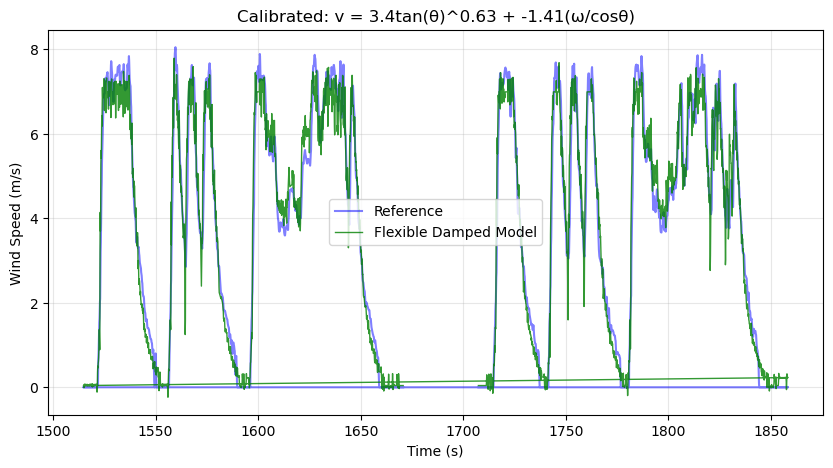

In [126]:
# %% [markdown]
# # 3. Flexible Physics Model with Damping
# # Model: v = a * (tan(theta))^b + c * (omega / cos(theta))
# # This combines an empirical power-law static response with a dynamic damping correction.

# %%
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Calculate Angular Velocity (omega) ---
# We need the time derivative of the angle: d(theta)/dt
omega_rad_s = np.gradient(angle_rad, t)

# --- 2. Prepare Data for Curve Fit ---
# Clip angle slightly to avoid asymptotes
th_safe = np.clip(angle_rad, -np.deg2rad(85), np.deg2rad(85))

tan_theta_vals = np.tan(th_safe)
cos_theta_vals = np.cos(th_safe)
omega_vals     = omega_rad_s

# Filter valid data
# We filter for finite values. We use all data points (including swinging back) 
# to help the optimizer learn the damping term 'c'.
mask_damp = np.isfinite(tan_theta_vals) & np.isfinite(v_ref) & np.isfinite(omega_vals)

X_fit_damped = (tan_theta_vals[mask_damp], cos_theta_vals[mask_damp], omega_vals[mask_damp])
Y_fit_damped = v_ref[mask_damp]

# --- 3. Define the New Flexible Model ---
def model_v_flexible(X, a, b, c):
    tan_th, cos_th, omega = X
    
    # 1. Static Term: Power Law (a * tan(theta)^b)
    # This generalizes the v ~ sqrt(tan) relationship (where b would be 0.5).
    # We use abs() to handle small negative noise in angles safely.
    term_static = a * (np.abs(tan_th) ** b)
    
    # 2. Dynamic Term: Damping Correction
    # Accounts for the plate's motion (angular velocity omega).
    # c is the damping coefficient.
    term_dynamic = c * (omega / cos_th)
    
    # Total estimated wind speed
    return term_static + term_dynamic

# --- 4. Perform Fit ---
# Initial Guesses
# a: Scaling factor (approx 15 based on previous steps)
# b: Exponent (starts at 0.5, representing the square root relationship)
# c: Damping (starts at 0)
p0 = [15.0, 0.5, 0.0]

# Bounds
# a > 0
# b in [0.2, 1.5] (physics suggests 0.5, but aerodynamics might vary)
# c unbounded (can be positive or negative depending on sign convention of omega)
bounds = ([0, 0.2, -np.inf], [np.inf, 1.5, np.inf])

try:
    popt, pcov = curve_fit(
        model_v_flexible, 
        X_fit_damped, 
        Y_fit_damped, 
        p0=p0, 
        bounds=bounds,
        maxfev=5000
    )
    a_opt, b_opt, c_opt = popt
except Exception as e:
    print(f"Fitting failed: {e}")
    a_opt, b_opt, c_opt = 15.0, 0.5, 0.0

# --- 5. Evaluate and Report ---
# Calculate predictions on the full dataset for plotting
X_full = (tan_theta_vals, cos_theta_vals, omega_vals)
v_pred_flexible = model_v_flexible(X_full, a_opt, b_opt, c_opt)

# Metrics on the fitted subset
v_fit_pred = model_v_flexible(X_fit_damped, a_opt, b_opt, c_opt)
R2_flex = r2_score(Y_fit_damped, v_fit_pred)
MSE_flex = mean_squared_error(Y_fit_damped, v_fit_pred)

print(f"=== Flexible Model with Damping ===")
print(f"Model: v = {a_opt:.4f} * tan(θ)^{b_opt:.4f} + {c_opt:.4f} * (ω/cos(θ))")
print(f"a (Scale)    = {a_opt:.4f}")
print(f"b (Exponent) = {b_opt:.4f} (Physics expectation ~0.5)")
print(f"c (Damping)  = {c_opt:.4f}")
print(f"R² = {R2_flex:.4f}")
print(f"MSE = {MSE_flex:.4f}")

# Plotting
plt.figure(figsize=(10,5))
plt.plot(t, v_ref, label="Reference", color="blue", alpha=0.5)
plt.plot(t, v_pred_flexible, label="Flexible Damped Model", color="green", alpha=0.8, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Wind Speed (m/s)")
plt.title(f"Calibrated: v = {a_opt:.1f}tan(θ)^{b_opt:.2f} + {c_opt:.2f}(ω/cosθ)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [127]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# %% Define the Extended Model v = a * (tan(theta))^b + c * theta^d
def model_v_extended(theta_rad, a, b, c, d):
    # Clip angles to avoid infinite tan at 90 deg or negative inputs
    # Using 85 deg limit as in your original code
    th_adj = np.clip(theta_rad, 0, np.deg2rad(85))
    tan_th = np.tan(th_adj)
    
    # Ensure non-negative bases for power operations
    tan_th = np.maximum(0, tan_th)
    th_val = np.maximum(0, theta_rad) 
    
    return a * (tan_th ** b) + c * (th_val ** d)

# --- Fitting ---
# Initial guesses:
# a, b: approx 15, 0.5 (from previous fit)
# c, d: small correction terms (start with linear correction c=0.1, d=1.0)
p0 = [15.0, 0.5, 0.1, 1.0]

# Bounds:
# a: positive
# b: 0.2 to 1.0 (physics constraint)
# c: -100 to 100 (allow negative correction)
# d: 0 to 5 (limit polynomial power)
bounds = ([0, 0.5, -10, 0], [100, 1.0, 10, 10])

# Perform the curve fit
popt, pcov = curve_fit(
    model_v_extended, 
    angle_rad[mask_fit], 
    v_ref[mask_fit], 
    p0=p0, 
    bounds=bounds
)

a, b, c, d = popt

# --- Evaluate ---
v_pred = model_v_extended(angle_rad, a, b, c, d)
mask_eval = np.isfinite(v_ref) & np.isfinite(v_pred)

R2 = r2_score(v_ref[mask_eval], v_pred[mask_eval])
MSE = mean_squared_error(v_ref[mask_eval], v_pred[mask_eval])

print(f"=== Extended Model: v = a * (tan θ)^b + c * θ^d ===")
print(f"a = {a:.4f}")
print(f"b = {b:.4f}")
print(f"c = {c:.4f}")
print(f"d = {d:.4f}")
print(f"R² = {R2:.4f}")
print(f"MSE = {MSE:.4f}")

=== Extended Model: v = a * (tan θ)^b + c * θ^d ===
a = 4.9976
b = 0.6871
c = -2.4326
d = 1.8387
R² = 0.9454
MSE = 0.4144


In [128]:
# %%
# Residual for R: z - true
residual = (v_pred - v_ref)
ekf_r = float(np.nanvar(residual))

# Diff of "true" for Q: Δv_true
if np.sum(np.isfinite(v_ref)) > 1:
    dv_true = np.diff(v_ref)
    ekf_q = float(np.nanvar(dv_true))
else:
    ekf_q = np.nan

# Guardrails
if not np.isfinite(ekf_r) or ekf_r <= 0: ekf_r = 0.05  # small default
if not np.isfinite(ekf_q) or ekf_q <= 0: ekf_q = 0.01

print("\n=== EKF parameter suggestions (wind-speed domain) ===")
print(f"Q (process noise)     ≈ {ekf_q:.6f}")
print(f"R (measurement noise) ≈ {ekf_r:.6f}")



=== EKF parameter suggestions (wind-speed domain) ===
Q (process noise)     ≈ 0.021219
R (measurement noise) ≈ 0.414340


In [129]:
# %%
def apply_ekf_1d(meas, q, r, p0=1.0, x0=0.0):
    """
    1D Kalman filter for scalar signal with random-walk process.
    meas: measurement array z_k
    """
    x = x0
    p = p0
    out = np.empty_like(meas, dtype=float)
    for i, z in enumerate(meas):
        # Predict
        x_pred = x
        p_pred = p + q
        # Update
        K = p_pred / (p_pred + r)
        x = x_pred + K * (z - x_pred)
        p = (1.0 - K) * p_pred
        out[i] = x
    return out

v_pred_ekf = apply_ekf_1d(v_pred, q=ekf_q, r=ekf_r, p0=1.0, x0=(v_pred[0] if np.isfinite(v_pred[0]) else 0.0))

R2_ekf  = r2_score(v_ref[mask_eval], v_pred_ekf[mask_eval])
MSE_ekf = mean_squared_error(v_ref[mask_eval], v_pred_ekf[mask_eval])

print("\n=== After EKF (applied to model output) ===")
print(f"R²  = {R2_ekf:.4f}")
print(f"MSE = {MSE_ekf:.6f} (m²/s²)")



=== After EKF (applied to model output) ===
R²  = 0.9828
MSE = 0.130744 (m²/s²)


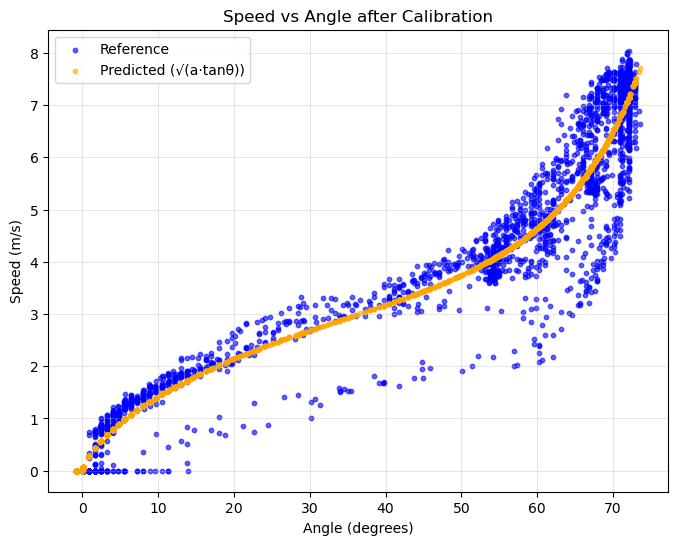

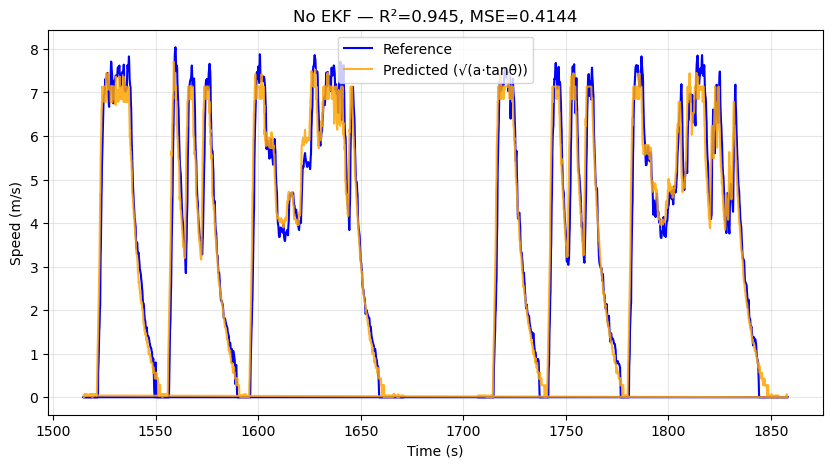

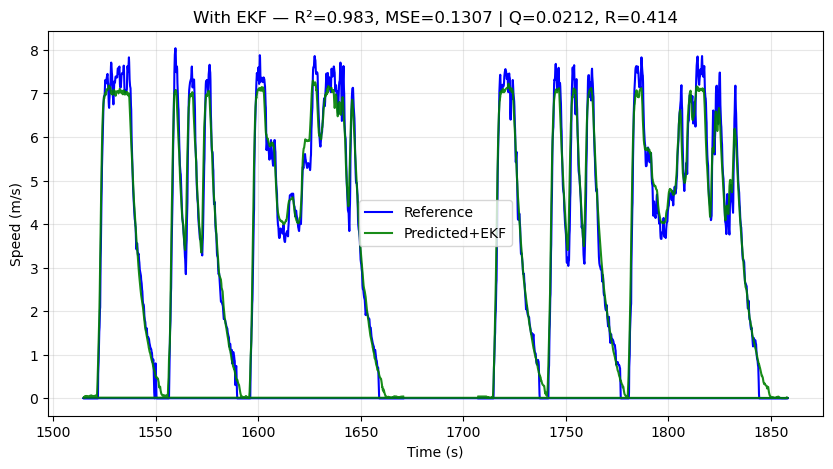

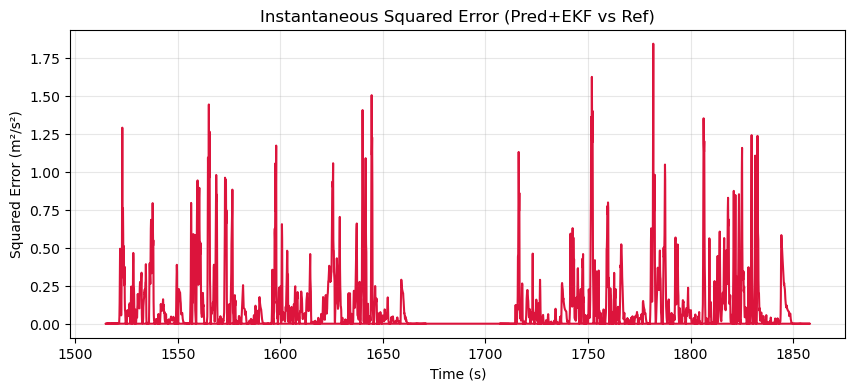

In [130]:
# (A) plot v against theta in degrees
plt.figure(figsize=(8,6))
plt.scatter(np.rad2deg(angle_rad), v_ref, label="Reference", color="blue", s=10, alpha=0.6)
plt.scatter(np.rad2deg(angle_rad), v_pred, label="Predicted (√(a·tanθ))", color="orange", s=10, alpha=0.6)
plt.xlabel("Angle (degrees)"); plt.ylabel("Speed (m/s)")
plt.title("Speed vs Angle after Calibration")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


# (B) Time-series comparison (no EKF vs ref)
plt.figure(figsize=(10,5))
plt.plot(t, v_ref, label="Reference", color="blue")
plt.plot(t, v_pred, label="Predicted (√(a·tanθ))", color="orange", alpha=0.85)
plt.xlabel("Time (s)"); plt.ylabel("Speed (m/s)")
plt.title(f"No EKF — R²={R2:.3f}, MSE={MSE:.4f}")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# (C) Time-series comparison (with EKF)
plt.figure(figsize=(10,5))
plt.plot(t, v_ref, label="Reference", color="blue")
plt.plot(t, v_pred_ekf, label="Predicted+EKF", color="green", alpha=0.9)
plt.xlabel("Time (s)"); plt.ylabel("Speed (m/s)")
plt.title(f"With EKF — R²={R2_ekf:.3f}, MSE={MSE_ekf:.4f} | Q={ekf_q:.3g}, R={ekf_r:.3g}")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# (D) Squared error over time (with EKF)
plt.figure(figsize=(10,4))
plt.plot(t, (v_ref - v_pred_ekf)**2, color="crimson")
plt.xlabel("Time (s)"); plt.ylabel("Squared Error (m²/s²)")
plt.title("Instantaneous Squared Error (Pred+EKF vs Ref)")
plt.grid(True, alpha=0.3); plt.show()
